# Project: food.ai
This is a Machine Learning Pipeline which classifies 101 different images of food dataset from Kaggel https://www.kaggle.com/datasets/dansbecker/food-101

Overview of this notebook:
1. Using TensorFlow Datasets to download and explore whole data of Food101
2. Creating a preprocessing function for our data
3. Batching and preparing datasets for modelling (making them run fast)
4. Setting up mixed precision training (use of both 16 and 32-bit float-point type for faster model training)
5. Building and training a **Feature Extraction Transfer Learning** model
6. Fine-tuning the feature extraction model to beat the DeepFood Paper
7. Evaluating the model results by making and plotting Predictions

> **Note:** Among NVIDIA GPUs, those with compute capability 7.0 or higher will see the greatest performance benefit from **mixed precision** because they have special hardware units, called Tensor Cores, to accelerate float16 matrix multiplications and convolutions. Source: https://www.tensorflow.org/guide/mixed_precision

> In my case, I currently have access to NVIDIA GeForce RTX 2060/GeForce GTX 1650 Ti, which has compute capability of 7.5. Source: https://developer.nvidia.com/cuda-gpus

In [1]:
# GPU Check
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-694ef843-97f6-b3eb-bb69-5539274f049e)


In [2]:
# import required libraries
import tensorflow as tf
import matplotlib.pyplot as plt

2025-01-15 13:25:13.580861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736918713.701196    6105 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736918713.733786    6105 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 13:25:13.978079: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Get helper functions
We've written a number of helper functions that are frequently utilized in our scripts. We can then import that script and load every function from it. My github has that script available for us.

In [3]:
# Download helper functions script
#!wget https://raw.githubusercontent.com/rajiblama743/Extra/refs/heads/main/helper_functions.py

In [4]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFLow Datasets to download Data 
TensorFlow Datasets is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks...

Food101 happens to be one of them. Hurray...

Source: https://www.tensorflow.org/datasets/catalog/overview#all_datasets

In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [6]:
# Confirming if our dataset is in TensorFlow Datasets
datasets_list = tfds.list_builders() # gets all available datasets in tfds

print("Is our target dataset in the list of tfds datasets?")
if "food101" in datasets_list:
    print("-> There is. Yeah!")
else:
    print("-> Noooooo...")

2025-01-15 13:25:18.486980: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Is our target dataset in the list of tfds datasets?
-> There is. Yeah!


In [7]:
# Load in the data
(train_data, test_data), ds_ifo = tfds.load(name="food101",
                                           split=["train", "validation"],
                                           shuffle_files=True,
                                           as_supervised=True, # data gets returned in tupl format (data, label),
                                           with_info=True) # this loads the meta data along with tensors(image data) and store it in ds_info

I0000 00:00:1736918721.331112    6105 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4778 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


## Exploring the food101 data from TensorFLow Datasets

To become one with our data, we want to find:
1. class names
2. the shapes of our input data (image tensors)
3. the datatype of our input data
4. what the labels look like (e.g. are they one-hot encoded or ar they label encoded)
5. do the labels match up with the class names?

In [8]:
# Features of Food101 from tfds
ds_ifo.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_ifo.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our traininig sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)

2025-01-15 13:25:21.656341: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608



    Image shape: (306, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from food101 (tensor form): 29
    Class name (str form): cup_cakes
    


2025-01-15 13:25:22.253182: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# What does our image tensor from tfds's food101 look like?
image

<tf.Tensor: shape=(306, 512, 3), dtype=uint8, numpy=
array([[[199, 100,  15],
        [192,  91,   9],
        [202,  95,  23],
        ...,
        [238, 196, 124],
        [237, 195, 123],
        [236, 194, 122]],

       [[210, 110,  25],
        [207, 105,  23],
        [194,  86,  13],
        ...,
        [238, 196, 124],
        [236, 194, 122],
        [235, 193, 121]],

       [[205, 103,  18],
        [213, 108,  25],
        [196,  86,  11],
        ...,
        [238, 195, 126],
        [237, 194, 125],
        [235, 192, 123]],

       ...,

       [[ 95,  28,  11],
        [ 94,  27,  10],
        [ 84,  17,   0],
        ...,
        [166,  32,   5],
        [166,  32,   3],
        [167,  34,   1]],

       [[ 87,  24,   7],
        [ 83,  18,   0],
        [ 87,  20,   1],
        ...,
        [155,  27,   0],
        [164,  39,   9],
        [156,  33,   0]],

       [[ 83,  21,   6],
        [ 79,  16,   0],
        [ 85,  19,   0],
        ...,
        [149,  25,   

In [13]:
# What are the min and max values of our image tensor?

# Usually the values of the image are between 0 and 255
tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy()

(np.uint8(0), np.uint8(255))

### Plot an image from TensorFlow Datasets

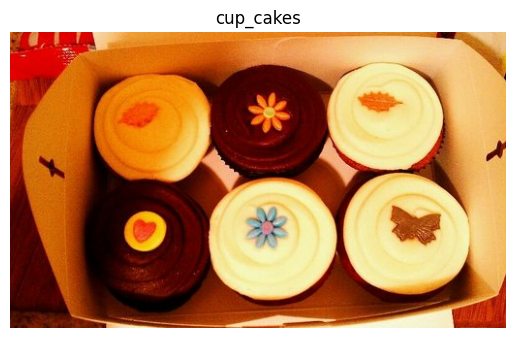

In [14]:
# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing function for our data

Neural Networks perform best when data is in a certain way (e.g. batched, normalized, etc.)

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write proprocessing functions and map it to your data.

What we know about our data:
- In `uint8` datatype
- Comprised of all different size tensors (different sized images)
- Not scaled (the pixel values are between 0 & 255)

What we know models like:
- Data in `float32` dtype (or for mixed precision `float16` and `float32`)
- For batches, TensorFlow likes all of the tensors within a batch to be of same size
- Scaled (values between 0 & 1) also called normalized tensors generally perform better

These are the points we need to tackle with a preprocessing function.

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes
    image to [img_shape, img_shape, colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
    #image = image/255. # Scale image values (not required with EfficientNetBX models from tf.keras.applications)
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}... \n Shape: {image.shape},\n Datatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}... \n Shape: {preprocessed_img.shape},\n Datatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[199 100  15]
  [192  91   9]
  [202  95  23]
  ...
  [238 196 124]
  [237 195 123]
  [236 194 122]]

 [[210 110  25]
  [207 105  23]
  [194  86  13]
  ...
  [238 196 124]
  [236 194 122]
  [235 193 121]]]... 
 Shape: (306, 512, 3),
 Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[196.98405    96.515305   13.443877 ]
  [185.15625    75.776146   10.615431 ]
  [176.09981    62.711414    9.320153 ]
  ...
  [237.2455    192.6027    122.24549  ]
  [238.        196.        124.       ]
  [236.4598    194.4598    122.459785 ]]

 [[209.20886   106.47194    23.047512 ]
  [168.58833    56.285706    0.8501243]
  [166.6894     53.45121     2.8341837]
  ...
  [236.62468   192.2172    121.85998  ]
  [238.50987   195.96077   125.60809  ]
  [235.9958    193.4467    123.09402  ]]]... 
 Shape: (224, 224, 3),
 Datatype: <dtype: 'float32'>



## Batch & prepare datasets
We're now going to make our data input pipeline run really fast.

Must read: https://www.tensorflow.org/guide/data_performance, because one of the key problem we're going to come across is loading data.

In [17]:
# Map the preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> So, what above code does is: "Hey, TensorFlow, map the preprocessing function (`preprocess_img`) across our training dataset, the shuffle a number of elements at a time and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks
We're going to create a callback to help us while our model trains:
- ModelCheckpoint callback to save our model's progress after feature extraction

In [19]:
# Create Modelcheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/checkpoint.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_acc",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)

## Setup mixed precision training
Mixed precision utilizses a combination of flota32 nad float16 data types to speed up model performance

In [20]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [23]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build Feature extraction model

In [28]:
from tensorflow.keras import layers
INPUT_SHAPE = (224, 224, 3)

# Create base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create functional model
inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")
#x = layers.Rescaling(1/255.)(x) # No need to normalize for EfficientNetBX models
x = base_model(inputs, training=False) # Makes sure the layers which should be in inference model only stay like that
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # Dense layer will stay in float16 while output will be in float32
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_catergorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [40]:
# Check the dtype_policy atrributes of layers in our model
for layer in model.layers:
    print(f"""
            Layer Name: {layer.name}
            Trainable: {layer.trainable}
            Layer dtype" {layer.dtype}
            Layer dtype policy: {layer.dtype_policy}
            """)


            Layer Name: input_layer
            Trainable: True
            Layer dtype" float32
            Layer dtype policy: <DTypePolicy "mixed_float16">
            

            Layer Name: efficientnetb0
            Trainable: False
            Layer dtype" float32
            Layer dtype policy: <DTypePolicy "mixed_float16">
            

            Layer Name: global_average_pooling_layer
            Trainable: True
            Layer dtype" float32
            Layer dtype policy: <DTypePolicy "mixed_float16">
            

            Layer Name: dense_1
            Trainable: True
            Layer dtype" float32
            Layer dtype policy: <DTypePolicy "mixed_float16">
            

            Layer Name: softmax_float32
            Trainable: True
            Layer dtype" float32
            Layer dtype policy: <DTypePolicy "float32">
            


> * `layer.name`: name of a particular layer
> * `layer.trainable`: trainable status of layer (if `False`, the weights are frozen)
> * `layer.dtype`: the data type a layer stores its variable in
> * `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [46]:
# Check the dtype_policy attributes of layers in base_model
for layer in model.layers[1].layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 False float32 <DTypePolicy "mixed_float16">
rescaling_2 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
rescaling_3 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl